In [201]:
import numpy as np
from scipy.linalg import solve_banded

In [208]:
def init_basic(mode):
    global t_start, x_start, K, E, alpha, dz, a, b, z_steps, t_steps, teta, dt, r_X, r_T, D, kappa, Q, C, R, T0, Tm, U
    
    if mode == 'regular':
        D = 8e-8
        K = 1.6e6
        E = 1e4
    
    if mode == '2period':
        D = 8e-12
        K = 4.6e6
        E = 8.5e4
    
    if mode == 'chaos':
        D = 8e-12
        K = 1e8
        E = 1.02e5  
    D = 8e-8
    alpha = 0.5
    dz = 1e-4
    dt = 1e-2
    a = 0
    b = 3e-2
    R = 8.31
    ro = 830
    C = 1990
    Q = 7e5
    T0 = 293
    Tm = T0 + Q / C
    lambd = 0.13
    kappa = lambd / (ro * C)
    z_steps = int((b - a) / dz)
    teta = 500
    t_steps = int(teta / dt)
    t_start = np.zeros(z_steps, dtype=np.float64)
    x_start = np.zeros(z_steps, dtype=np.float64)
    r_X = D * dt / (dz ** 2)
    r_T = kappa * dt / (dz ** 2)
    U = (2 * K * lambd / (Q * ro * Q / C) * T0 / Tm * ((R * Tm * Tm / E) ** 2) * np.exp(-E / (R * Tm))) ** 0.5
    
            
    t_start[0] = Tm
    x_start[0] = 0
    for i in range(1, z_steps):
        t_start[i] = T0
        x_start[i] = 1
    

def W(X, T):
    return -K * (X ** alpha) * np.exp(-E / (R * T))

In [209]:
K = 1e8
E = 1.02e5
alpha = 1.0
Q = 7e5
ro = 830
C = 1990
lambd = 0.13
D = 8e-12
R = 8.31
T0 = 293 # начальная температура
Tm = T0 + Q / C # конечная температура
kappa = lambd / (ro * C)
U = (2 * K * lambd / (Q * ro * Q / C) * T0 / Tm * ((R * Tm * Tm / E) ** 2) * np.exp(-E / (R * Tm))) ** 0.5
beta = R * Tm / E
gamma = R * Tm * Tm / (E * Q / C)
delta_h = kappa / U
delta_r = beta * delta_h
delta_d = D / U
Le = delta_d / delta_h

# Регулярный режим
# D = 8e-8
# K = 1.6e6
# E = 8e4

# Двухпериодический режим
# D = 8e-12
# K = 4.6e6
# E = 8.5e4

# Хаос
# D = 8e-12
# K = 1e8
# E = 1.02e5

b = 3e-2
dz = 1e-4
z_steps = int((b-a) / dz)

teta = 500
dt = 1e-2
t_steps = int(teta / dt)

r_X = D * dt / (dz ** 2)
r_T = kappa * dt / (dz ** 2)


t_start = np.zeros(z_steps, dtype=np.float64)
x_start = np.zeros(z_steps, dtype=np.float64)

for i in range(1):
    t_start[i] = Tm
    x_start[i] = 0
for i in range(1, z_steps):
    t_start[i] = T0
    x_start[i] = 1

In [199]:
def W_vectorized(X, T):
    return -K*np.multiply((np.power(X, alpha)), np.exp(-E/R * np.reciprocal(T)))

In [186]:
def solve(solver):
    Ts = [t_start]
    Xs = [x_start]
    
    for cur_iter in range(1, t_steps + 1):
#         print(cur_iter)
#         print(Xs[0], end='\n\n\n')
        t = dt * cur_iter
        cur_t, cur_x = solver(t, Ts[-1], Xs[-1])
        Ts.append(cur_t)
        Xs.append(cur_x)

    return Ts, Xs

In [187]:
def explicit_opposite(t, prevT, prevX):
    next_t_row = np.zeros(z_steps, dtype=np.float64)
    next_x_row = np.zeros(z_steps, dtype=np.float64)
    
    for i in range(1, z_steps - 1):
        prev_t = prevT[i - 1]
        next_t = prevT[i + 1]
        cur_t = prevT[i]
        
        prev_x = prevX[i - 1]
        next_x = prevX[i + 1]
        cur_x = prevX[i]
        
        next_t_row[i] = cur_t + r_T * (prev_t + next_t - 2 * cur_t) - Q/C * dt * W(cur_x, cur_t)
        next_x_row[i] = cur_x + r_X * (prev_x + next_x - 2 * cur_x) + dt * W(cur_x, cur_t)
    
    next_t_row[0] = Tm
    next_t_row[z_steps - 1] = next_t_row[z_steps - 2]
    
    next_x_row[0] = 0
    next_x_row[z_steps - 1] = next_x_row[z_steps - 2]
    return next_t_row, next_x_row


In [193]:
def solve_linear(a, b, c, d):
    nf = len(d)
    ac, bc, cc, dc = map(np.array, (a, b, c, d))
    for it in range(1, nf):
        mc = ac[it - 1] / bc[it - 1]
        bc[it] = bc[it] - mc * cc[it - 1] 
        dc[it] = dc[it] - mc * dc[it - 1]
    xc = bc
    xc[-1] = dc[-1] / bc[-1]
    for il in range(nf - 2, -1, -1):
        xc[il] = (dc[il] - cc[il] * xc[il + 1]) / bc[il]
    return xc


In [194]:
def implicit(t, prevT, prevX):
    T_r = dt * kappa / (dz ** 2)
    X_r = dt * D / (dz ** 2)
    
    T_a = np.repeat(T_r, z_steps)
    T_b = np.repeat(-1 - 2 * T_r, z_steps)
    T_c = np.repeat(T_r, z_steps)
    T_a[-2] = 0
    T_b[0] = 1
    T_b[z_steps - 1] = 1
    T_c[1] = 0
    
    X_a = np.repeat(X_r, z_steps)
    X_b = np.repeat(-1 - 2 * X_r, z_steps)
    X_c = np.repeat(X_r, z_steps)
    X_a[-2] = 0
    X_b[0] = 1
    X_b[z_steps - 1] = 1
    X_c[1] = 0
    
    W_values = W_vectorized(prevX, prevT)
    X_d = -dt * W_values - prevX
    T_d = Q * dt / C * W_values - prevT
    
    X_d[0] = 0
    T_d[0] = Tm
    T_d[z_steps - 1] = T0    
    X_d[z_steps - 1] = 1
    
    newT = solve_banded((1, 1), np.array([T_c, T_b, T_a]), T_d, overwrite_ab=True, overwrite_b=True, check_finite=True)
    newX = solve_banded((1, 1), np.array([X_c, X_b, X_a]), X_d, overwrite_ab=True, overwrite_b=True, check_finite=True)
    return newT, newX

In [188]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def create_animation(target, ymax):

    fig = plt.figure()
    ax = plt.axes(xlim=(a, b), ylim=(0, ymax))
    
    step = int(len(target) / 500)

    line, = ax.plot([], [])

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        z = np.linspace(a, b, 300)
        T = target[i * step]
        line.set_data(z, T)
        return line,
    
    
    anim = FuncAnimation(fig, animate, init_func=init, frames=490, interval=30)

    return anim

def create_sequential(target, name, charts_number):
    step = int(len(target) / charts_number)
    for i in range(charts_number):
#         print(i * step)
        plt.plot(np.linspace(a, b, 300), target[i * step], color='red')
    plt.ylabel('target')
    plt.xlabel('z')
    plt.savefig(name + '.png')
    plt.show()    


In [197]:

def run(mode, s=False, a=False, i=False):
    init_basic(mode)
    if s:
        print('Solving...')
        Ts, Xs = solve(implicit)
    if a:
        T_from_z = create_animation(Ts, 700)
        print('Saving animations...')
        T_from_z.save('t_from_z_{}.gif'.format(mode), writer='imagemagick')
        X_from_z = create_animation(Xs, 1.2)
        X_from_z.save('x_from_z_{}.gif'.format(mode), writer='imagemagick')

    if i:
        print('Drawing plots...')
        create_sequential(Ts, mode + '_Ts', 100)
        create_sequential(Xs, mode + '_Xs', 100)
    print('Done')
    return Ts, Xs

In [207]:
print(r_X, r_T)
print(delta_r)
print(Le, K*np.exp(-E/(R*Tm)))

0.08 0.07870678694678211
0.00021850815738610585
0.0001016430769230769 0.5398485148070851


In [206]:
Ts, Xs = run('chaos', True, True, False)

Solving...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


ValueError: array must not contain infs or NaNs

In [168]:
Ts[2600]

array([644.75879397, 644.81662646, 644.8104941 , 644.44861377,
       643.16023233, 640.17062681, 634.6700331 , 626.07805633,
       614.29756122, 599.78133312, 583.34860167, 565.89236115,
       548.16251485, 530.68816661, 513.79628277, 497.66545477,
       482.37833415, 467.96050237, 454.40566942, 441.69076519,
       429.78451158, 418.65209838, 408.25764033, 398.56541384,
       389.54044151, 381.14873885, 373.3573928 , 366.13456228,
       359.44944743, 353.27225087, 347.57414227, 342.32723064,
       337.50454561, 333.08002709, 329.0285222 , 325.32578754,
       321.94849537, 318.87424193, 316.08155645, 313.54990958,
       311.25972033, 309.19236033, 307.33015511, 305.65638172,
       304.15526248, 302.81195466, 301.6125362 , 300.54398746,
       299.59416928, 298.7517976 , 298.00641512, 297.34836009,
       296.76873304, 296.25936157, 295.81276375, 295.42211061,
       295.08118799, 294.78435833, 294.5265225 , 294.30308227,
       294.10990346, 293.94328019, 293.79990037, 293.67

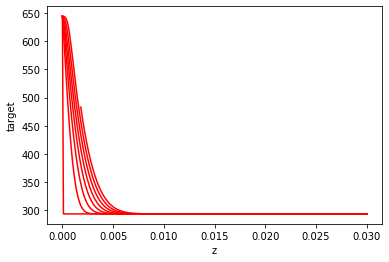

In [196]:
create_sequential(Ts, 'Ts_regular', 100)
# plt.plot(np.linspace(a, b, 300), Xs[2500])

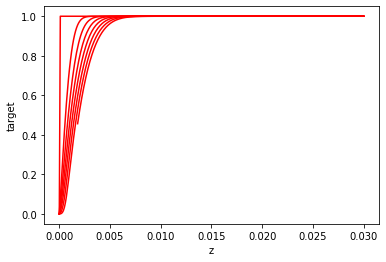

In [184]:
create_sequential(Xs, 'Xs_regular', 100)

In [181]:
(2 * K * 0.13 / (Q * 830 * Q / C) * T0 / Tm * ((R * Tm * Tm / E) ** 2) * np.exp(-E / (R * Tm))) ** 0.5

2.379469583783956e-05